In [21]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdc
import cv2 as cv
from skimage.morphology import skeletonize
from scipy import ndimage
import shutil
import math
import warnings
warnings.filterwarnings('ignore', '.*output shape of zoom.*')
from PIL import Image

# === SubFunction(Convert pixel matrix into png image without axis) ===

def img_show(img_mtx, figsize=(12,12)):
    plt.figure(figsize=figsize)
    plt.imshow(img_mtx, cmap='gray')
    plt.axis('off')
    plt.show()  

# ======

# === SubFunction ===

def edge_detect(img):   
    canny = cv.Canny(img, 0, 1)
    kernel = np.ones((2,2), np.uint8)
    edge = cv.dilate(canny, kernel, iterations = 1)
    x,y,w,h = cv.boundingRect(edge)
    
    return edge,x,y,w,h

# ======

# === SubFunction ===

def img_save(img, save_file, output_dir):     
    save_path = os.path.join(output_dir,save_file)
    plt.imsave(save_path,img,cmap='gray')
    # print('file saved : {}'.format(save_path))  
    
    return save_path

# ======

# === Function ===

def dcm_to_img(file_src_path, output_dir):
    ds = pdc.dcmread(file_src_path)
    img = ds.pixel_array.reshape(ds.pixel_array.shape[0],ds.pixel_array.shape[1])                
    img[np.where(img==-2000)] = 0

    x = cv.Sobel(img,cv.CV_16S,1,0)
    y = cv.Sobel(img,cv.CV_16S,0,1)

    absX = cv.convertScaleAbs(x)
    absY = cv.convertScaleAbs(y)

    dst = cv.addWeighted(absX, 0.5, absY, 0.5, 0)

    blur = cv.GaussianBlur(dst, (39, 39), 0)
    _, thresh_mask = cv.threshold(blur,200,1,cv.THRESH_BINARY)

    masked_img = img.copy()
    masked_img[np.where(thresh_mask==0)] = 0  
    
    # save_path = img_save(masked_img, 'test_dcm.png', output_dir)
    
    return thresh_mask, masked_img

# ======

# ======

def skeletionize_img(thresh_mask, masked_img):

    blur = cv.GaussianBlur(masked_img, (71, 71), 100)
    blur_img = cv.addWeighted(masked_img, 1.5, blur, -0.5, 0)

    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpen_img = cv.filter2D(masked_img,-1,filter)        

    sharpen = cv.addWeighted(blur_img, 0.1, sharpen_img, 0.9, 0)

    _, sharpen_thresh = cv.threshold(sharpen,np.mean(sharpen),1,cv.THRESH_BINARY)

    global skeleton
    skeleton = (255*skeletonize(sharpen_thresh)).astype(np.uint8)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
    skeleton_dilated = cv.morphologyEx(skeleton, cv.MORPH_DILATE, kernel)

    kernel = np.ones((2,2), np.uint8)
    erosion = cv.erode(skeleton_dilated , kernel, iterations = 1) 

    edge,x,y,w,h = edge_detect(thresh_mask)
    
    save_path = img_save(erosion, 'test_porosity.png', output_dir)
    with Image.open(save_path) as img:
        img = img.convert('L')
        img.load()    
    output = img.crop((x, y, x+w, y+h))
    crop_img = np.array(output,np.uint8)
    
    os.remove(save_path)

    pixels_white = np.where(crop_img>0)[0].shape[0]
    pixels_black = np.where(crop_img==0)[0].shape[0]
    porosity = pixels_black/(pixels_white+pixels_black)    
    
    if porosity < 0.7:
        img_skeletionize = skeleton
    else:
        img_skeletionize = erosion

    return img_skeletionize, edge

# ======

# ======

def rescale_img(img, rescale_num):
    
    height, width = img.shape
    wi = (width/2)
    he = (height/2)

    M = cv.moments(img)

    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    offsetX = (wi-cX)
    offsetY = (he-cY)

    T = np.float32([[1, 0, offsetX], [0, 1, offsetY]]) 
    centered_image = cv.warpAffine(img, T, (width, height))

    rescale_image = ndimage.zoom(centered_image, rescale_num, order=1, mode='nearest', cval=0.0)     
    
    return rescale_image

# ======

# ======

def cropped_img(rescale_image, rescale_num, new_size):
       
    x = cv.Sobel(rescale_image,cv.CV_16S,1,0)
    y = cv.Sobel(rescale_image,cv.CV_16S,0,1)

    absX = cv.convertScaleAbs(x)
    absY = cv.convertScaleAbs(y)

    dst = cv.addWeighted(absX, 0.5,absY,0.5,0)

    blur = cv.GaussianBlur(dst, (39, 39), 0)
    _, thresh_img = cv.threshold(rescale_image,np.mean(rescale_image),1,cv.THRESH_BINARY)

    edge,x,y,w,h = edge_detect(thresh_img)
    # img_rect = cv.rectangle(edge,(x,y),(x+w,y+h),(255,255,255),2)

    center_width, center_height = (x+x+w)/2, (y+y+h)/2

    save_path = img_save(rescale_image, 'test.png', output_dir)
    with Image.open(save_path) as img:
        img = img.convert('L')
        img.load()         
    output = img.crop((center_width-int(new_size), center_height-int(new_size), 
                       center_width+int(new_size), center_height+int(new_size)))        
    crop_img = np.array(output,np.uint8) 
    
    os.remove(save_path)
    
    _, thresh_crop = cv.threshold(crop_img,np.mean(crop_img),1,cv.THRESH_BINARY)
    
    if rescale_num==1:
        crop_erosion = thresh_crop
    else:
        kernel = np.ones((2,2), np.uint8)
        crop_erosion = cv.erode(thresh_crop , kernel, iterations = 1) 
    
    return crop_erosion

# ======

# ======

def cropped_img_edge(rescale_image, rescale_image_edge, rescale_num, new_size):
       
    x = cv.Sobel(rescale_image,cv.CV_16S,1,0)
    y = cv.Sobel(rescale_image,cv.CV_16S,0,1)

    absX = cv.convertScaleAbs(x)
    absY = cv.convertScaleAbs(y)

    dst = cv.addWeighted(absX, 0.5,absY,0.5,0)

    blur = cv.GaussianBlur(dst, (39, 39), 0)
    _, thresh_img = cv.threshold(rescale_image,np.mean(rescale_image),1,cv.THRESH_BINARY)

    edge,x,y,w,h = edge_detect(thresh_img)
    # img_rect = cv.rectangle(edge,(x,y),(x+w,y+h),(255,255,255),2)

    center_width, center_height = (x+x+w)/2, (y+y+h)/2

    save_path = img_save(rescale_image_edge, 'test.png', output_dir)
    with Image.open(save_path) as img:
        img = img.convert('L')
        img.load()         
    output = img.crop((center_width-int(new_size), center_height-int(new_size), 
                       center_width+int(new_size), center_height+int(new_size)))        
    crop_img = np.array(output,np.uint8) 
    
    os.remove(save_path)
    
    _, thresh_crop = cv.threshold(crop_img,np.mean(crop_img),1,cv.THRESH_BINARY)
    
    if rescale_num==1:
        crop_erosion = thresh_crop
    else:
        kernel = np.ones((2,2), np.uint8)
        crop_erosion = cv.erode(thresh_crop , kernel, iterations = 1) 
    
    return crop_erosion

# ======

In [22]:
# ======

"""
======
Get the width and height of the terminal window.
======
"""

width, height = shutil.get_terminal_size((80, 20))

# ======

# ======

"""
    :param work_dir (str) : Current working directory
    :param main_dir (str) : Always be set to ./SuperBone_ver1
    :param output_dir (str) : The default directory where all outputs are stored
"""  

work_dir = os.getcwd()
main_dir = os.path.dirname(work_dir)
initial_dir = os.path.join(os.path.dirname(main_dir),'dcm_src')   
output_dir = os.path.join(main_dir,'test')

# ======

import FileChooser

"""
======
Initialize the class and set the initial directory, file type, and the type of file/folder to choose
======
    :param initial_dir (str) : Initial directory to open the file dialog
    :param file_type (str) : The type of file to select (e.g. "Image", "DICOM",...)
    :param choose_type (str) : The type of file/folder to select ("File", "Folder", "Multiple Files")
"""  

selector = FileChooser.Selector(initial_dir, file_type = "DICOM", choose_type = "File")

# ======

"""
======
Open a file dialog windows and return the source path
    :param file_src_path (str) : The absolute path of the source image
======
"""

file_src_path = selector.run()

# ======

Import File : D:/dcm_src/Aves/Rheiformes/Rheidae/Rhea_americana-greater_rhea/tibia/RHEA TBT _Se2_Im030.dcm


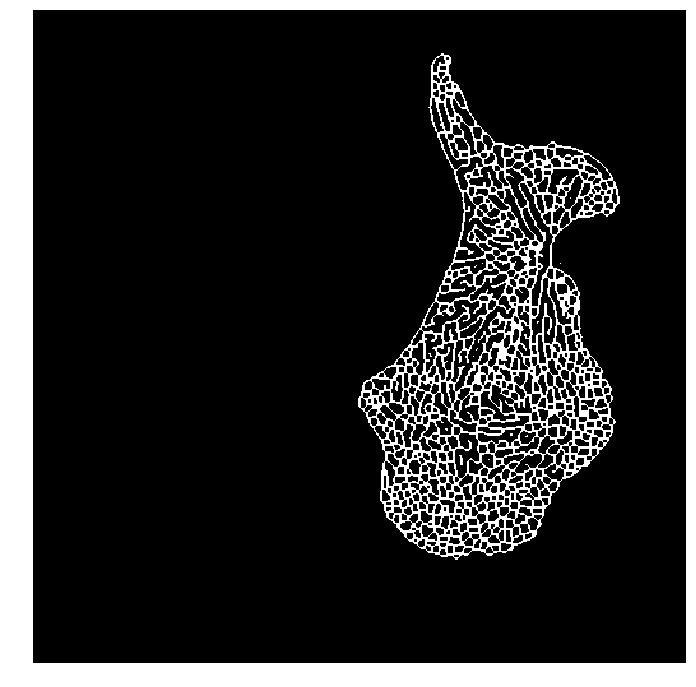

file saved : D:\SuperBone_ver1.20\test\test_sketeton_1.6.png


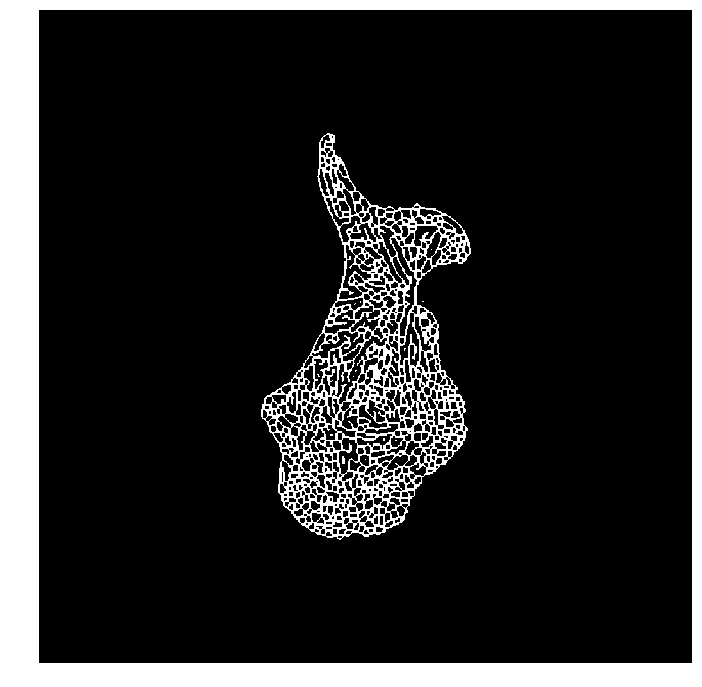

file saved : D:\SuperBone_ver1.20\test\test_sketeton_edge_1.6.png


In [23]:
rescale_num = 1.6

thresh_mask, masked_img = dcm_to_img(file_src_path, output_dir)
img_skeletionize, edge = skeletionize_img(thresh_mask, masked_img)

img_show(img_skeletionize)
rescale_image = rescale_img(img_skeletionize, rescale_num)
crop_erosion = cropped_img(rescale_image, rescale_num, new_size = 510)
# img_show(crop_erosion)
save_path = img_save(crop_erosion, 'test_sketeton_{}.png'.format(round(rescale_num,2)), output_dir)
print('file saved : {}'.format(save_path))

img_show(crop_erosion)

rescale_image_edge = rescale_img(edge, rescale_num)
crop_erosion_edge = cropped_img_edge(rescale_image, rescale_image_edge, rescale_num, new_size = 510)
save_path = img_save(crop_erosion_edge, 'test_sketeton_edge_{}.png'.format(round(rescale_num,2)), output_dir)
print('file saved : {}'.format(save_path))

# img_show(crop_erosion_edge)